# Motif Search

I want to search for transcription factor binding sites that
are disrupted by potential QTNs.

In [376]:
import copy
import os

from Bio.Seq import Seq
import cdpybio as cpb
import matplotlib.pyplot as plt
import MOODS
import numpy as np
import pandas as pd
import pybedtools as pbt
import seaborn as sns
import weblogolib as logo

import cardipspy as cpy
import ciepy

from IPython.display import Image 

%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [390]:
outdir = os.path.join(ciepy.root, 'output',
                      'motif_search')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'motif_search')
cpy.makedir(private_outdir)

In [2]:
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)
qvalues.columns = ['{}_gene'.format(x) for x in qvalues.columns]
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'most_sig.tsv')
most_sig = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'functional_annotation_analysis',
                  'encode_stem_cell_chip_seq.tsv')
encode_chip_seq = pd.read_table(fn, index_col=0)

In [3]:
import urllib2
import zlib
from StringIO import StringIO

def read_gzipped_text_url(url):
    """Read a gzipped text file from a URL and return 
    contents as a string."""
    # Create a opener
    opener = urllib2.build_opener() 

    request = urllib2.Request(url)
    request.add_header('Accept-encoding', 'gzip')

    # Fetch the gzip filer
    respond = opener.open(request)
    compressedData = respond.read()
    respond.close()

    opener.close()

    # Extract data and save to text file
    compressedDataBuf = StringIO(compressedData)
    d = zlib.decompressobj(16+zlib.MAX_WBITS)

    buffer = compressedDataBuf.read(1024)
    #saveFile = open('/tmp/test.txt', "wb")
    s = []
    while buffer:
        s.append(d.decompress(buffer))
        buffer = compressedDataBuf.read(1024)
    s = ''.join(s)
    return s

In [4]:
most_sig = most_sig.join(qvalues)
sig = most_sig[most_sig.sig_gene]

The columns in the Kheradpour file are ACGT.

In [5]:
key = []
tf = []
cell_line = []
source = []
length = []
with open(cpy.kheradpour_motifs) as f:
    lines = f.read()
m = lines.split('>')[1:]
m = [x.split('\n')[:-1] for x in m]
matrices = {}
for x in m:
    k = x[0].split()[0]
    key.append(k)
    if 'transfac' in x[0]:
        tf.append(x[0].split()[1].split('_')[0].upper())
        cell_line.append(np.nan)
        source.append('transfac')
    elif 'jolma' in x[0]:
        tf.append(x[0].split()[1].split('_')[0].upper())
        cell_line.append(np.nan)
        source.append('jolma')
    elif 'jaspar' in x[0]:
        tf.append(x[0].split()[1].split('_')[0].upper())
        cell_line.append(np.nan)
        source.append('jaspar')
    elif 'bulyk' in x[0]:
        tf.append(x[0].split()[1].split('_')[0].upper())
        cell_line.append(np.nan)
        source.append('bulyk')
    else:
        tf.append(x[0].split()[1].split('_')[0].upper())
        cell_line.append(x[0].split()[1].split('_')[1])
        source.append('encode')
    t = pd.DataFrame([y.split() for y in x[1:]],
                     columns=['base', 'A', 'C', 'G', 'T'])
    t.index = t.base
    t = t.drop('base', axis=1)
    t = t.convert_objects(convert_numeric=True)
    matrices[k] = t
    length.append(t.shape[0])

motif_info = pd.DataFrame({'tf': tf, 'cell_line': cell_line, 'source': source, 
                           'length': length}, index=key)

In [6]:
lines = (sig.chrom + '\t' + (sig.coord - 1).astype(str) + 
         '\t' + sig.coord.astype(str) + '\t' + sig.chrom +
         ':' + sig.coord.astype(str))
lines = lines.drop_duplicates()
sig_bt = pbt.BedTool('\n'.join(lines + '\n'), from_string=True)
m = max([x.shape[0] for x in matrices.values()])
sig_bt = sig_bt.slop(l=m, r=m, g=pbt.genome_registry.hg19)
seqs = sig_bt.sequence(fi=cpy.hg19)
sig_seqs = [x.strip() for x in open(seqs.seqfn).readlines()]
sig_seqs = pd.Series(sig_seqs[1::2], index=[x[1:] for x in sig_seqs[0::2]])
sig_seqs = sig_seqs.apply(lambda x: x.upper())

In [7]:
snvs = sig[['chrom', 'coord', 'loc', 'marker_id']]
snvs.index = snvs['loc'].values
snvs = snvs.drop_duplicates()
snvs['ref'] = snvs.marker_id.apply(lambda x: x.split('_')[1].split('/')[0])
snvs['alt'] = snvs.marker_id.apply(lambda x: x.split('_')[1].split('/')[1])

snvs['interval'] = ''
snvs['seq'] = ''
snvs['alt_seq'] = ''
for i in sig_seqs.index:
    chrom, start, end = cpb.general.parse_region(i)
    k = '{}:{}'.format(chrom, int(end) - m)
    snvs.ix[k, 'interval'] = i
    snvs.ix[k, 'seq'] = sig_seqs[i]
    ref, alt = snvs.ix[k, ['ref', 'alt']]
    assert sig_seqs[i][m] == ref
    snvs.ix[k, 'alt_seq'] = sig_seqs[i][0:m] + alt + sig_seqs[i][m + 1:]

I'm going to choose a representative motif for each TF. I'll preferentially choose
the motifs from H1-hESC experiments.

In [8]:
a = motif_info[motif_info.tf.apply(lambda x: x in encode_chip_seq.target.values)]
b = a[a.cell_line == 'H1-hESC']
b = b.drop_duplicates(subset='tf')
a = a[a.cell_line != 'H1-hESC']
a = a[a.tf.apply(lambda x: x not in b.tf.values)]
a['so'] = a.source.replace({'jolma': 0, 'bulyk': 1, 'transfac': 2, 
                            'jaspar': 3, 'encode': 4})
a = a.sort(columns='so')
a = a.drop_duplicates(subset='tf').drop('so', axis=1)
motif_info = pd.concat([b, a])

In [9]:
encode_chip_seq = encode_chip_seq[encode_chip_seq.target.apply(lambda x: x in motif_info.tf.values)]
encode_chip_seq = encode_chip_seq.drop_duplicates(subset='target')

There are a few TF ChIP-seq datasets for which I don't have motifs. I can't find
them by hand in the Kheradpour data either. I'll skip these for now.

In [16]:
lines = (sig.chrom + '\t' + (sig.coord - 1).astype(str) + 
         '\t' + sig.coord.astype(str) + '\t' + sig.chrom +
         ':' + sig.coord.astype(str))
lines = lines.drop_duplicates()
sig_bt = pbt.BedTool('\n'.join(lines + '\n'), from_string=True)
sig_bt = sig_bt.sort()

In [27]:
snvs_tf = pd.DataFrame(False, index=snvs.index, columns=encode_chip_seq.target)
for i in encode_chip_seq.index:
    c = encode_chip_seq.ix[i, 'target']
    snvs_tf[c] = False
    bt = pbt.BedTool(read_gzipped_text_url(encode_chip_seq.ix[i, 'narrowPeak_url']), 
                     from_string=True)
    bt = bt.sort()
    res = sig_bt.intersect(bt, sorted=True, wo=True)
    for r in res:
        snvs_tf.ix['{}:{}'.format(r.chrom, r.end), c] = True

In [494]:
snv_motifs = {}
#for i in snvs_tf[snvs_tf.sum(axis=1) > 0].index:
for i in ['chr1:146644199']:
    se = snvs_tf.ix[i]
    se = se[se]
    keys = motif_info[motif_info.tf.apply(lambda x: x in se.index)].index
    ms = [matrices[x].T.values.tolist() for x in keys]
    seq_res = MOODS.search(snvs.ix[i, 'seq'], ms, 0.001, both_strands=True, 
                           bg=[0.25, 0.25, 0.25, 0.25])
    seq_mres = dict(zip(keys, seq_res))
    alt_seq_res = MOODS.search(snvs.ix[i, 'alt_seq'], ms, 0.001, both_strands=True, 
                               bg=[0.25, 0.25, 0.25, 0.25])
    alt_seq_mres = dict(zip(keys, alt_seq_res))
    if seq_mres != alt_seq_mres:
        for k in seq_mres.keys():
            if seq_mres[k] == alt_seq_mres[k]:
                seq_mres.pop(k)
                alt_seq_mres.pop(k)
            else:
                shared = set(seq_mres[k]) & set(alt_seq_mres)
                seq_mres[k] = [x for x in seq_mres[k] if x not in shared]
                alt_seq_mres[k] = [x for x in alt_seq_mres[k] if x not in shared]
                a = seq_mres[k]
                print('first', k, a)
                to_remove = []
                for v in a:
                    sp = len(snvs.ix[i, 'seq']) / 2 
                    start = v[0]
                    if start < 0:
                        start = start + len(snvs.ix[i, 'seq'])
                    if not start <= sp <= start + motif_info.ix[k, 'length']:
                        print(v)
                        to_remove.append(v)
                for v in to_remove:
                    a.remove(v)
                seq_mres[k] = a
                a = alt_seq_mres[k]
                to_remove = []
                for v in a:
                    sp = len(snvs.ix[i, 'seq']) / 2 
                    start = v[0]
                    if start < 0:
                        start = start + len(snvs.ix[i, 'seq'])
                    if not start <= sp < start + motif_info.ix[k, 'length']:
                        to_remove.append(v)
                for v in to_remove:
                    a.remove(v)
                alt_seq_mres[k] = a
        snv_motifs[i] = [seq_mres, alt_seq_mres]

('first', 'RAD21_disc7', [(15, 3.9474764434611007), (31, 4.343954948580402), (-31, 4.074765980429026)])
(31, 4.343954948580402)
('first', 'SIN3A_disc1', [(-37, 5.897621244820922)])
('first', 'EP300_disc9', [(18, 5.09946208612312), (24, 4.0524801130079915), (-52, 3.650658784768004), (-36, 5.01474146727589), (-33, 4.156225333319624), (-20, 4.498303233758044)])
(-52, 3.650658784768004)
(-20, 4.498303233758044)


TODO: Why is (15, 3.9474764434611007) being included in `seq_mres` below?
I think it should be filtered out because the motif length is only 15.
I should probably refactor the code above and do some careful checking of 
the indexing/length stuff.

In [490]:
# chr1_146644199_RAD21_disc7_31.png
snv = 'chr1:146644199'
seq_mres, alt_seq_mres = snv_motifs[snv]

In [483]:
motif_info.ix['RAD21_disc7', 'length']

15

In [495]:
seq_mres

{'EP300_disc9': [(18, 5.09946208612312),
  (24, 4.0524801130079915),
  (-36, 5.01474146727589),
  (-33, 4.156225333319624)],
 'RAD21_disc7': [(15, 3.9474764434611007), (-31, 4.074765980429026)],
 'SIN3A_disc1': [(-37, 5.897621244820922)]}

In [492]:
alt_seq_mres

{'EP300_disc9': [(18, 5.113584517939072),
  (24, 3.9148735122505554),
  (-36, 3.7761782685808867)],
 'RAD21_disc7': [],
 'SIN3A_disc1': []}

In [465]:
for k in seq_mres.keys():
    if seq_mres[k] == alt_seq_mres[k]:
        seq_mres.pop(k)
        alt_seq_mres.pop(k)
    else:
        shared = set(seq_mres[k]) & set(alt_seq_mres)
        seq_mres[k] = [x for x in seq_mres[k] if x not in shared]
        alt_seq_mres[k] = [x for x in alt_seq_mres[k] if x not in shared]
        a = seq_mres[k]
        for v in a:
            sp = len(snvs.ix[i, 'seq']) / 2 
            start = v[0]
            if start < 0:
                start = start + len(snvs.ix[i, 'seq'])
            if not start <= sp <= start + motif_info.ix[k, 'length']:
                a.remove(v)
        seq_mres[k] = a
        a = alt_seq_mres[k]
        for v in a:
            print(v)
            sp = len(snvs.ix[i, 'seq']) / 2 
            start = v[0]
            if start < 0:
                start = start + len(snvs.ix[i, 'seq'])
            if not start <= sp < start + motif_info.ix[k, 'length']:
                a.remove(v)
        alt_seq_mres[k] = a

(31, 4.343954948580402)
(18, 5.113584517939072)
(24, 3.9148735122505554)
(-36, 3.7761782685808867)


In [464]:
snvs.ix[snv, 'seq'][30:]

'CCCGGGACCCGCCGGCCTCTCTAGCCGCCGC'

In [457]:
motif_info.ix['RAD21_disc7']

cell_line    H1-hESC
length            15
source        encode
tf             RAD21
Name: RAD21_disc7, dtype: object

In [452]:
def plot_tf_disruption(m, ref, alt, fn, title=None):
    """m is the PWM, ref is the ref sequence, alt is the alt sequence"""
    k = 'SIX5_disc2'
    alphabet = logo.corebio.seq.unambiguous_dna_alphabet
    prior = [0.25, 0.25, 0.25, 0.25]
    counts = m.values
    assert counts.shape[1] == 4
    assert len(ref) == len(alt) == counts.shape[0]
    ref_counts = []
    for t in ref:
        ref_counts.append([int(t.upper() == 'A'), int(t.upper() == 'C'),
                           int(t.upper() == 'G'), int(t.upper() == 'T')])
    alt_counts = []
    for t in alt:
        alt_counts.append([int(t.upper() == 'A'), int(t.upper() == 'C'),
                           int(t.upper() == 'G'), int(t.upper() == 'T')])
    counts = np.concatenate([counts, ref_counts, alt_counts])
    data = logo.LogoData.from_counts(alphabet, counts, prior=None)
    fout = open(fn, 'w')
    options = logo.LogoOptions()
    options.fineprint = ''
    if title:
        options.logo_title = title
    else:
        options.logo_title = ''
    options.stacks_per_line = m.shape[0]
    options.show_xaxis = False
    options.show_yaxis = False
    options.color_scheme = logo.ColorScheme([logo.ColorGroup("G", "orange"), 
                                             logo.ColorGroup("C", "blue"),
                                             logo.ColorGroup("A", "green"),
                                             logo.ColorGroup("T", "red")])
    logo_format = logo.LogoFormat(data, options)
    fout.write(logo.png_print_formatter(data, logo_format))
    #fout.write(logo.pdf_formatter(data, logo_format))
    fout.close()
    Image(filename=fn)

In [ ]:
for k in snv_motifs.keys()[0:10]:
    print k, snv_motifs[k]
    print

TODO: I need to remove motif matches that are the same between alt and ref
(or at least don't overlap the variant).
Currently I only check if there is at least one difference.

In [453]:
cpy.makedir(os.path.join(outdir, 'tf_plots'))
for snv in snv_motifs.keys():
    seq_mres, alt_seq_mres = snv_motifs[snv]
    for k in seq_mres.keys():
        pwm = matrices[k]
        a = seq_mres[k]
        b = alt_seq_mres[k]
        starts = set([x[0] for x in a]) | set([x[0] for x in b])
        for start in starts:
            ref_seq = snvs.ix[snv, 'seq'][start: start + motif_info.ix[k, 'length']]
            alt_seq = snvs.ix[snv, 'alt_seq'][start: start + motif_info.ix[k, 'length']]
            if start < 0:
                ref_seq = str(Seq(ref_seq).reverse_complement())
                alt_seq = str(Seq(alt_seq).reverse_complement())
            fn = os.path.join(outdir, 'tf_plots', '{}_{}_{}.png'.format(
                snv.replace(':', '_'), k, str(start).replace('-', 'neg')))
            plot_tf_disruption(pwm, ref_seq, alt_seq, fn)

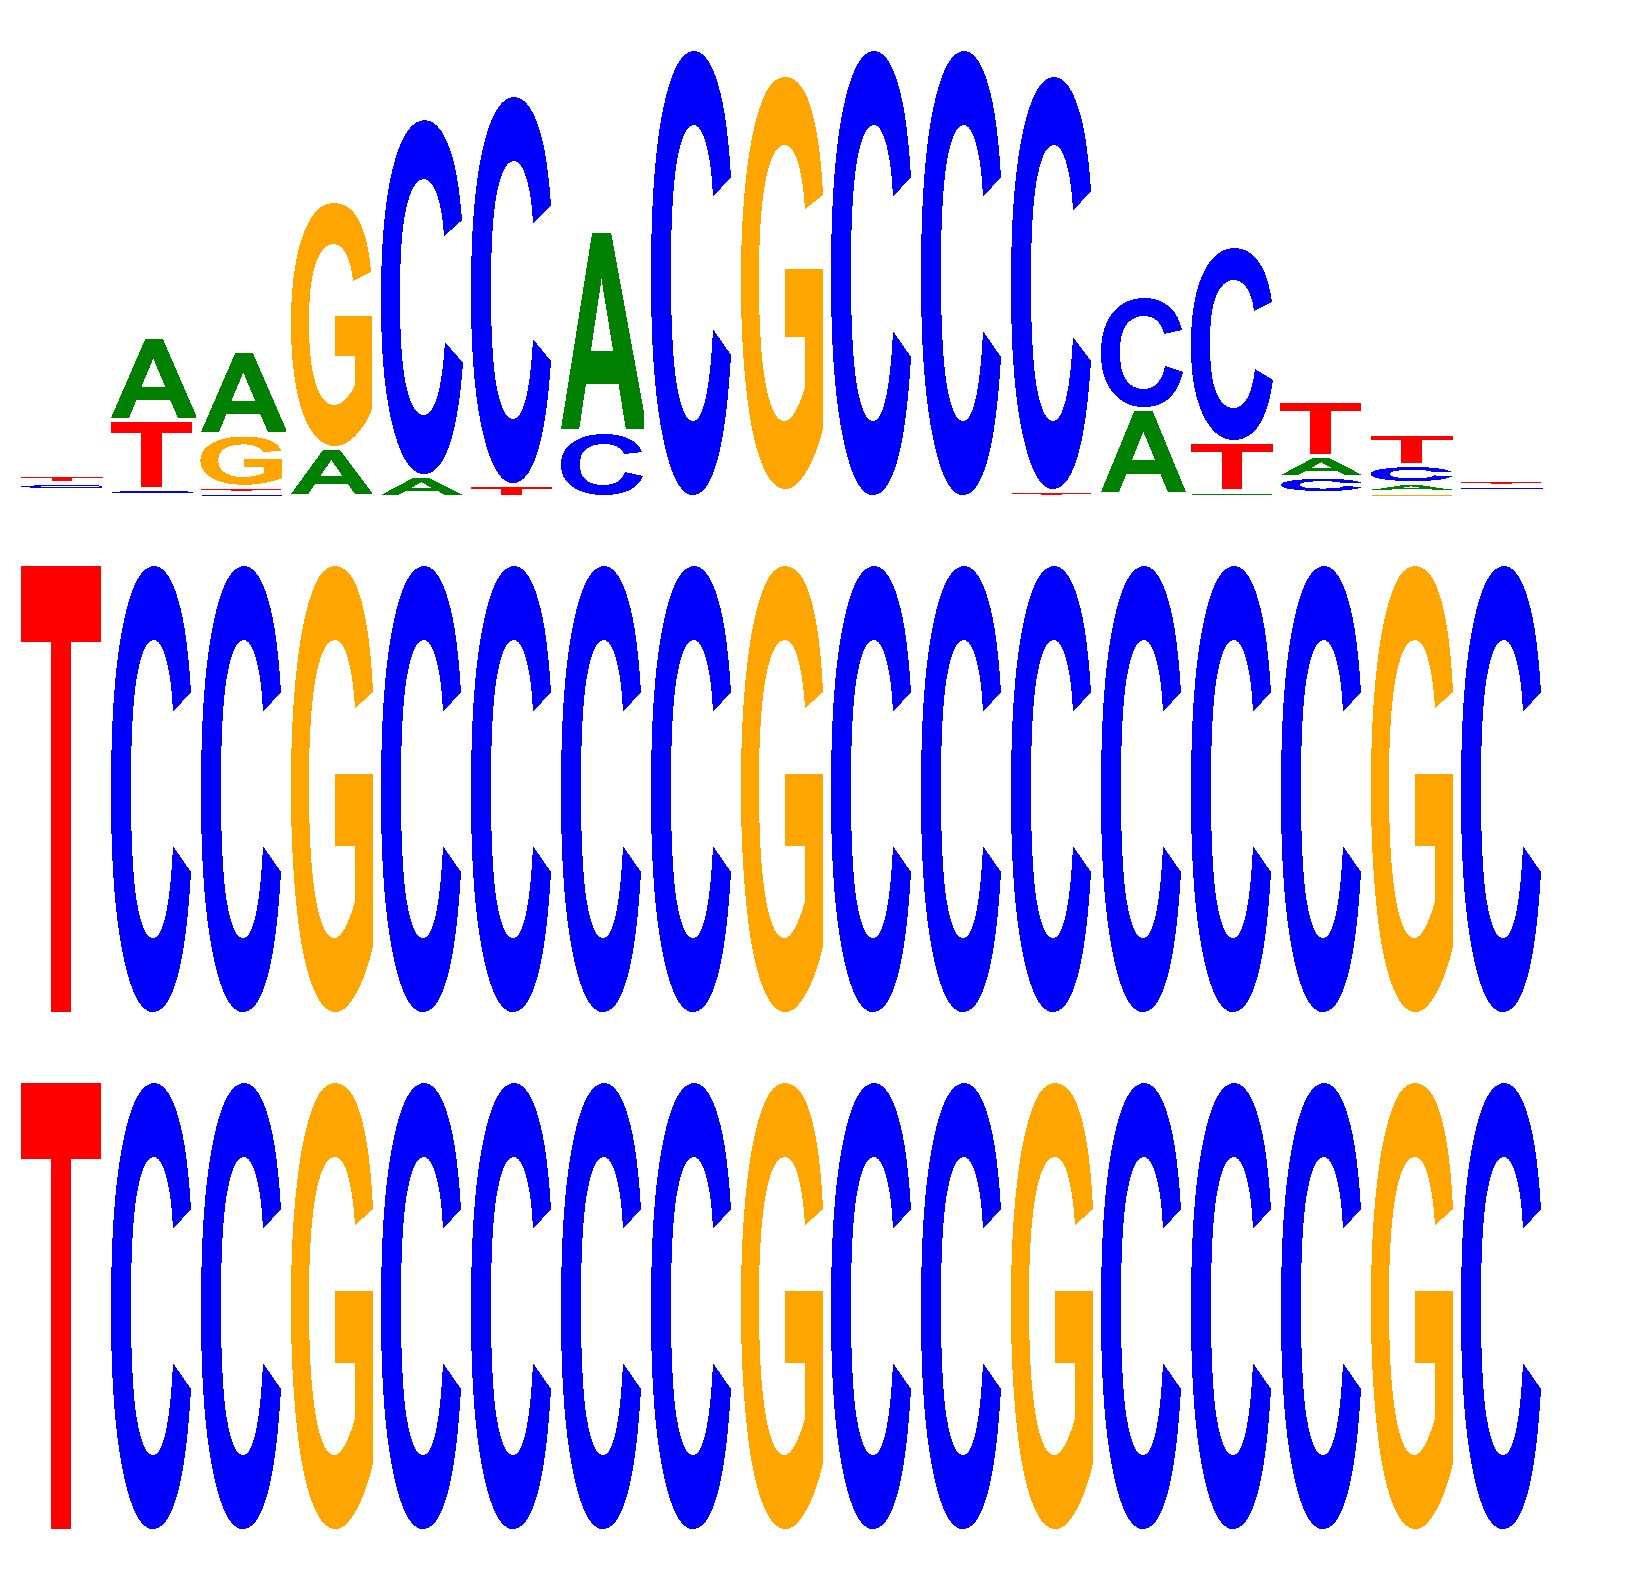

In [387]:
plot_tf_disruption(pwm, ref_seq, alt_seq, 'test.png')
Image(filename='test.png', width=300, height=300)

In [496]:
snvs.head()

,chrom,coord,loc,marker_id,ref,alt,interval,seq,alt_seq
chr1:24716529,chr1,24716529,chr1:24716529,1:24716529_C/A,C,A,chr1:24716498-24716559,GGGCACCAGGGCTGGCCAAGGCCCCTCACTCCATGCCTTGGCTCCG...,GGGCACCAGGGCTGGCCAAGGCCCCTCACTACATGCCTTGGCTCCG...
chr1:24718075,chr1,24718075,chr1:24718075,1:24718075_T/C,T,C,chr1:24718044-24718105,CATTACCTTCTTATGAGGAAATCTCTTGGCTTGACTATTGAATCCT...,CATTACCTTCTTATGAGGAAATCTCTTGGCCTGACTATTGAATCCT...
chr6:46145461,chr6,46145461,chr6:46145461,6:46145461_C/G_rs2223776,C,G,chr6:46145430-46145491,GGAGGGGCATGTCATGACCAGAGCCACGAACATAATTCCTGAATCA...,GGAGGGGCATGTCATGACCAGAGCCACGAAGATAATTCCTGAATCA...
chr6:46145547,chr6,46145547,chr6:46145547,6:46145547_A/G_rs2206964,A,G,chr6:46145516-46145577,TTTATTTAATATCAATCTGTAATTGATATTAAAATTAACGTTGCTT...,TTTATTTAATATCAATCTGTAATTGATATTGAAATTAACGTTGCTT...
chr12:1054956,chr12,1054956,chr12:1054956,12:1054956_C/T_rs147560086,C,T,chr12:1054925-1054986,GAACCCAGTAATCCCAGCACTTTGGGAGGCCGAGGCAGGCAGATCA...,GAACCCAGTAATCCCAGCACTTTGGGAGGCTGAGGCAGGCAGATCA...
